   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dimensiones del dataset: (200, 5)
<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    str  
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4), str(1)
memory usage: 7.9 KB
None
       CustomerID         Age  Annual 

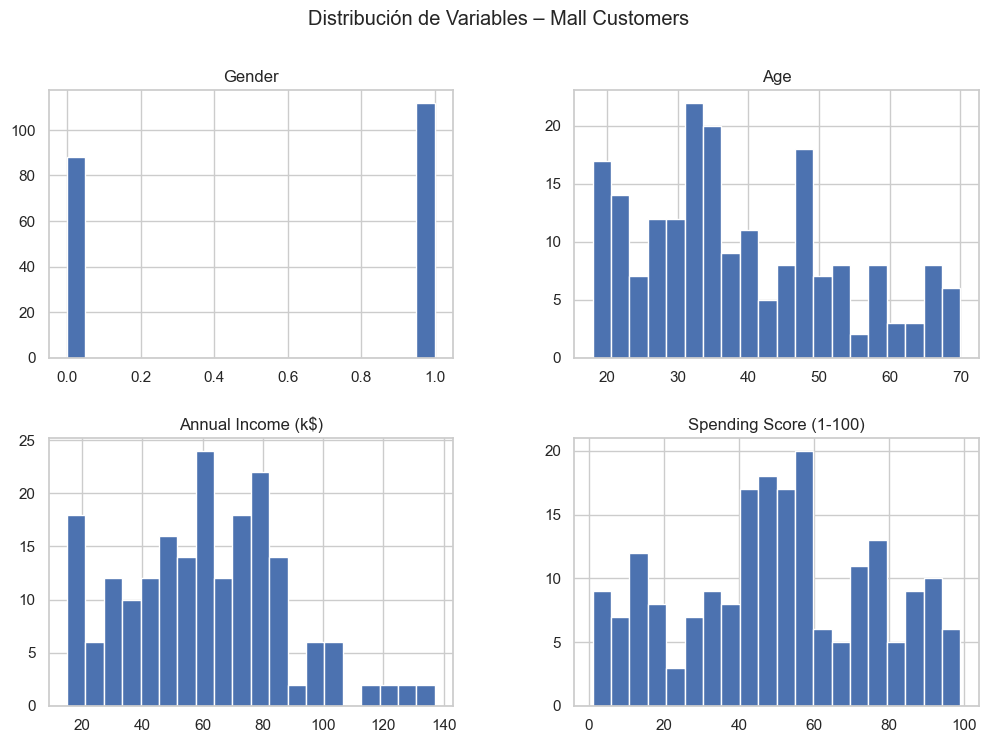

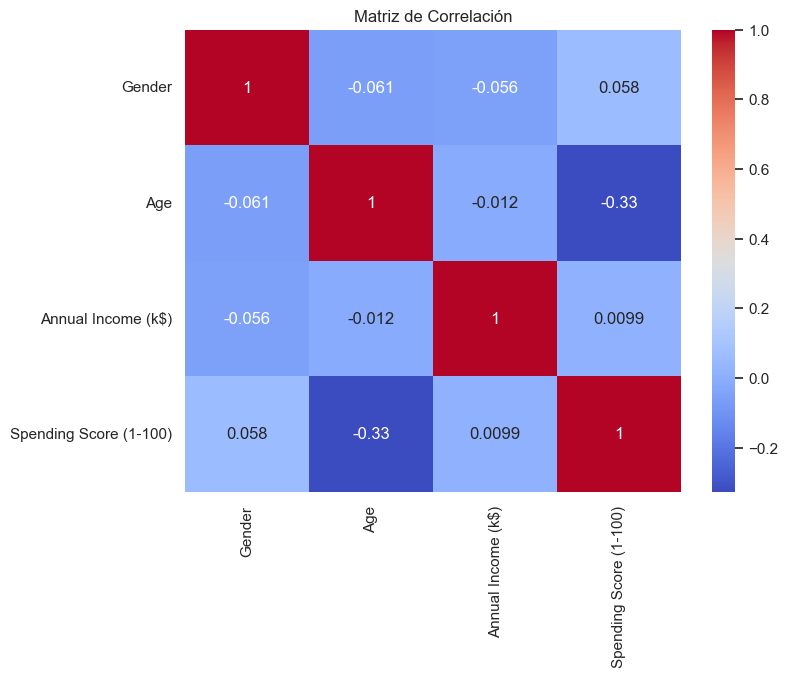

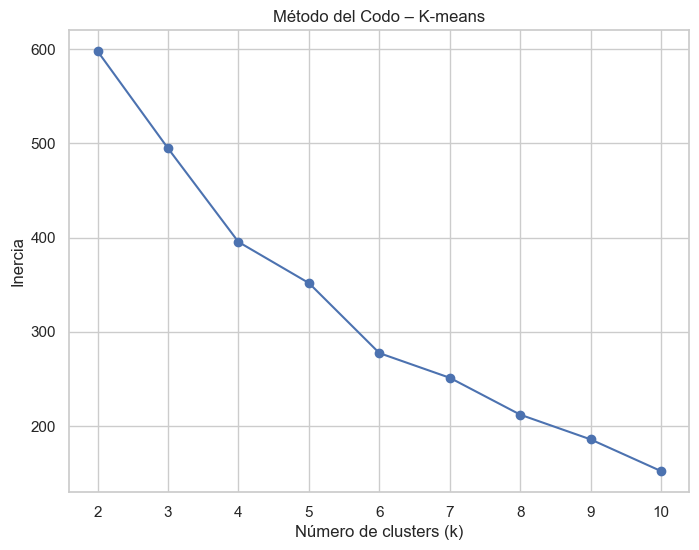

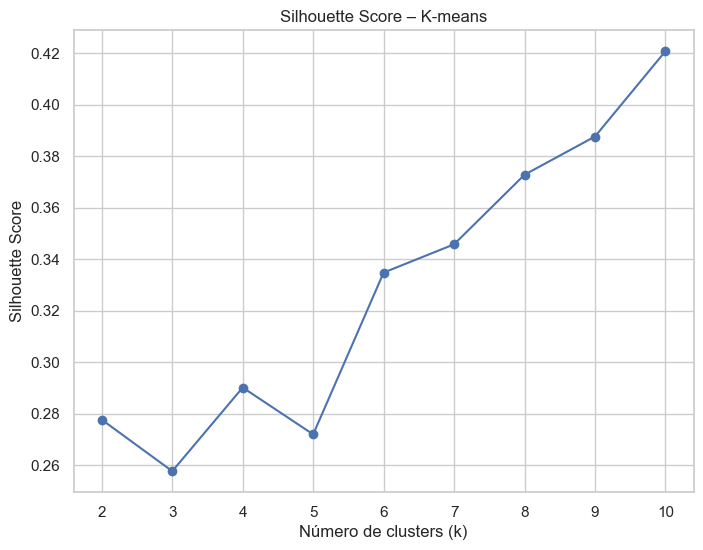

Clusters DBSCAN (sin ruido): 2


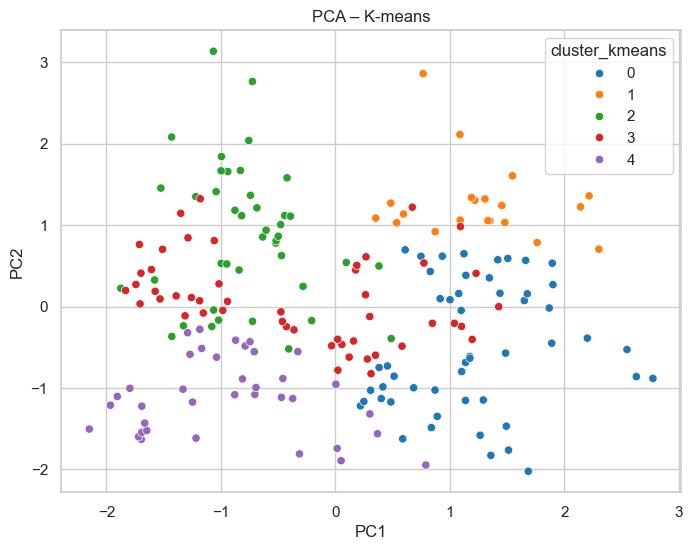

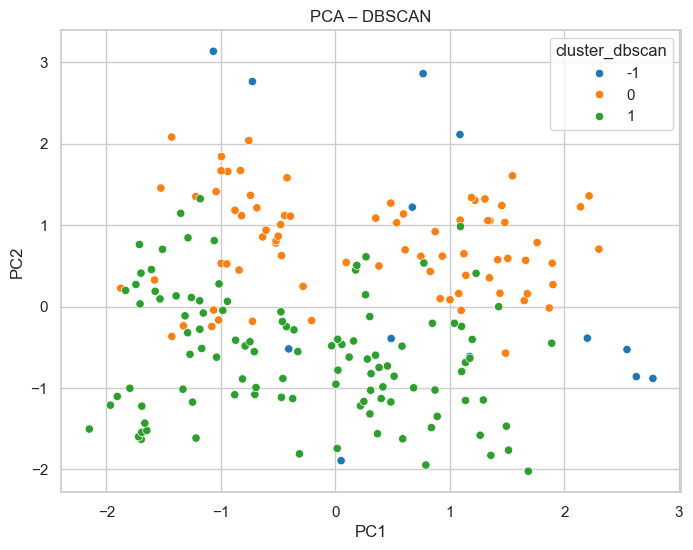

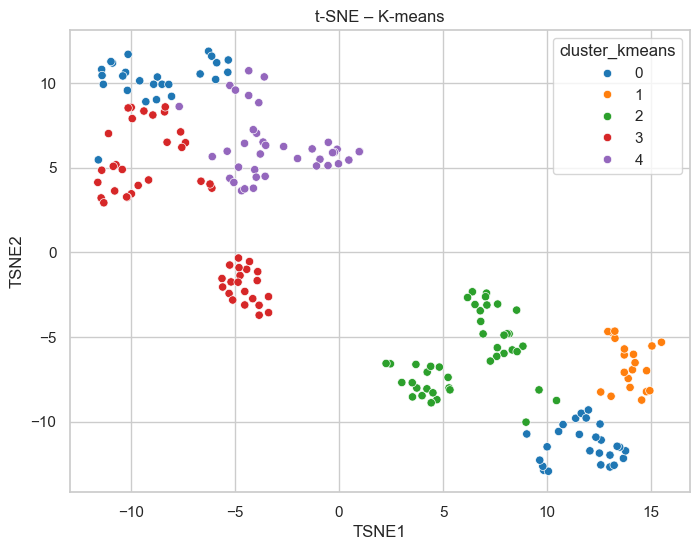

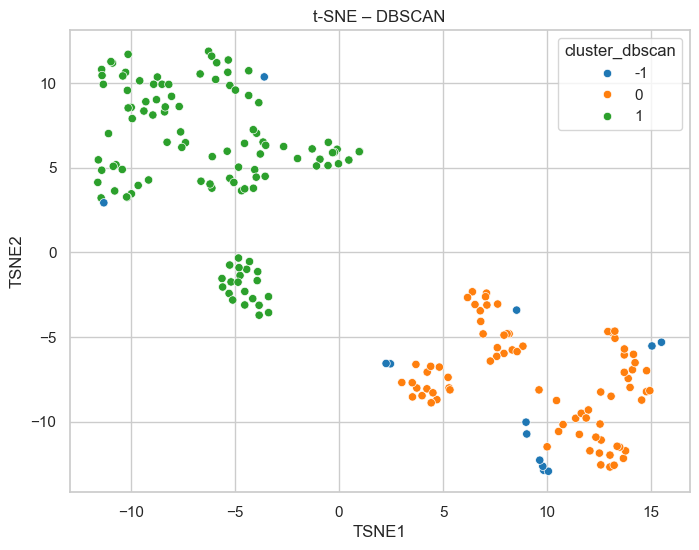

Resumen K-means:
                  Gender        Age  Annual Income (k$)  \
cluster_kmeans                                            
0               0.490196  56.470588           46.098039   
1               0.000000  39.500000           85.150000   
2               0.000000  28.690476           60.904762   
3               1.000000  37.897959           82.122449   
4               1.000000  27.315789           38.842105   

                Spending Score (1-100)  cluster_dbscan  
cluster_kmeans                                          
0                            39.313725        0.392157  
1                            14.050000       -0.100000  
2                            70.238095       -0.095238  
3                            54.448980        0.959184  
4                            56.210526        0.947368  

Resumen DBSCAN:
                Gender        Age  Annual Income (k$)  Spending Score (1-100)  \
cluster_dbscan                                                          

In [2]:
# =========================================================
# Proyecto: Segmentación de Clientes con Aprendizaje No Supervisado
# Dataset: Mall Customers (Kaggle)
# Modelos: K-means, DBSCAN, PCA y t-SNE
# =========================================================

# =========================
# 1. Importación de librerías
# =========================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# =========================
# 2. Carga del Dataset (Kaggle)
# =========================

# Dataset: Mall Customers Dataset
# Fuente: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
# Colocar el archivo CSV en la carpeta /data

file_path = "../data/Mall_Customers.csv"
df = pd.read_csv(file_path)

print(df.head())
print("\nDimensiones del dataset:", df.shape)

# =========================
# 3. Exploración Inicial
# =========================

print(df.info())
print(df.describe())

# Eliminamos columna ID (no aporta información para clustering)
df = df.drop(columns=["CustomerID"])

# Codificación simple de variable categórica (Gender)
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})

# =========================
# 4. Análisis Exploratorio (EDA)
# =========================

# Distribución de variables

df.hist(bins=20, figsize=(12, 8))
plt.suptitle("Distribución de Variables – Mall Customers")
plt.savefig("../figures/distribucion_variables.png", bbox_inches="tight")
plt.show()

# Matriz de correlación

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.savefig("../figures/matriz_correlacion.png", bbox_inches="tight")
plt.show()

# =========================
# 5. Preprocesamiento
# =========================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# =========================
# 6. K-means
# =========================

# Método del codo

inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del Codo – K-means")
plt.savefig("../figures/elbow_kmeans.png", bbox_inches="tight")
plt.show()

# Silhouette Score

silhouette_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score – K-means")
plt.savefig("../figures/silhouette_kmeans.png", bbox_inches="tight")
plt.show()

# Entrenamiento final

k_optimo = 5
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# =========================
# 7. DBSCAN
# =========================

# Aplicación de DBSCAN

dbscan = DBSCAN(eps=0.9, min_samples=5)
df["cluster_dbscan"] = dbscan.fit_predict(X_scaled)

print("Clusters DBSCAN (sin ruido):", len(set(df["cluster_dbscan"])) - (1 if -1 in df["cluster_dbscan"].values else 0))

# =========================
# 8. PCA (Visualización 2D)
# =========================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster_kmeans"] = df["cluster_kmeans"]
pca_df["cluster_dbscan"] = df["cluster_dbscan"]

# PCA + K-means

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster_kmeans", palette="tab10")
plt.title("PCA – K-means")
plt.savefig("../figures/pca_kmeans.png", bbox_inches="tight")
plt.show()

# PCA + DBSCAN

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster_dbscan", palette="tab10")
plt.title("PCA – DBSCAN")
plt.savefig("../figures/pca_dbscan.png", bbox_inches="tight")
plt.show()

# =========================
# 9. t-SNE
# =========================

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["cluster_kmeans"] = df["cluster_kmeans"]
tsne_df["cluster_dbscan"] = df["cluster_dbscan"]

# t-SNE + K-means

sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="cluster_kmeans", palette="tab10")
plt.title("t-SNE – K-means")
plt.savefig("../figures/tsne_kmeans.png", bbox_inches="tight")
plt.show()

# t-SNE + DBSCAN

sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="cluster_dbscan", palette="tab10")
plt.title("t-SNE – DBSCAN")
plt.savefig("../figures/tsne_dbscan.png", bbox_inches="tight")
plt.show()

# =========================
# 10. Perfilamiento por cluster
# =========================

# K-means

kmeans_summary = df.groupby("cluster_kmeans").mean()
kmeans_summary.to_csv("../figures/perfiles_cluster_kmeans.csv")

print("Resumen K-means:")
print(kmeans_summary)

# DBSCAN (sin ruido)

dbscan_filtered = df[df["cluster_dbscan"] != -1]
if not dbscan_filtered.empty:
    dbscan_summary = dbscan_filtered.groupby("cluster_dbscan").mean()
    dbscan_summary.to_csv("../figures/perfiles_cluster_dbscan.csv")
    print("\nResumen DBSCAN:")
    print(dbscan_summary)

# =========================
# 11. Conclusiones
# =========================

# - K-means genera segmentos claros y fáciles de interpretar.
# - DBSCAN identifica clientes atípicos (ruido).
# - PCA y t-SNE facilitan la visualización de los clusters.
# - Los resultados son útiles para estrategias de marketing segmentadas.

# Fin del Notebook
